In [1]:
%matplotlib inline

import numpy as np
from pprint import pprint

from PIL import Image
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import grad
import torchvision
from torchvision import models, datasets, transforms

torch.manual_seed(50)

print(torch.__version__, torchvision.__version__)

1.7.1+cu110 0.8.2+cu110


In [4]:
# 加载CIFAR-10数据集，如果本地没有则自动下载
dst = datasets.FashionMNIST("/home/raoxy/data", download=True)

In [5]:
# 定义一个转换序列，包括缩放、裁剪、转换为张量等操作
tp = transforms.Compose([
    transforms.Resize(28),
    transforms.CenterCrop(28),
    transforms.ToTensor()
])

# 定义一个函数，用于将张量转换为PIL图像
tt = transforms.ToPILImage()

# 检测是否有可用的GPU，如果有则使用GPU，否则使用CPU
device = "cpu"
if torch.cuda.is_available():
    device = "cuda"
print("Running on %s" % device)

Running on cuda


In [6]:
# 定义一个函数，用于将标签转换为one-hot编码的张量
def label_to_onehot(target, num_classes=10):
    # 在第一个维度上增加一个维度，使得target的形状为(N, 1)
    target = torch.unsqueeze(target, 1)
    # 创建一个全零的张量，形状为(N, num_classes)，设备与target相同
    onehot_target = torch.zeros(target.size(0), num_classes, device=target.device)
    # 在第二个维度上根据target的值将onehot_target的对应位置设为1
    onehot_target.scatter_(1, target, 1)
    # 返回onehot_target
    return onehot_target

# 定义一个函数，用于计算one-hot编码的标签和预测值之间的交叉熵损失
def cross_entropy_for_onehot(pred, target):
    # 对预测值进行log_softmax操作，然后与目标值相乘，再求和，最后求平均
    return torch.mean(torch.sum(- target * F.log_softmax(pred, dim=-1), 1))

# LeNet

In [7]:
# 定义一个类，继承自nn.Module，表示LeNet模型
class D_CNN(nn.Module):
        def __init__(self):
            super(D_CNN, self).__init__()
            self.conv1 = nn.Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
            self.pool1 = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0)
            self.conv2 = nn.Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
            self.pool2 = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0)
            self.fc1 = nn.Linear(64 * 7 * 7, 1000)
            self.fc2 = nn.Linear(1000, 10)

        def forward(self, x):
            x = self.conv1(x)
            x = nn.functional.relu(x)
            x = self.pool1(x)
            x = self.conv2(x)
            x = nn.functional.relu(x)
            x = self.pool2(x)
            x = x.view(-1, 64 * 7 * 7)
            x = self.fc1(x)
            feature = nn.functional.relu(x)
            out = self.fc2(feature)
#             x = nn.functional.softmax(feature, dim=1)
            return out,feature
    
# 创建一个LeNet模型的实例，并将其移动到设备上，可以是CPU或GPU
net = D_CNN().to(device)
net

D_CNN(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (pool1): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (pool2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=3136, out_features=1000, bias=True)
  (fc2): Linear(in_features=1000, out_features=10, bias=True)
)

In [8]:
# 定义一个函数，用于初始化模型的权重和偏置
def weights_init(m):
    # 如果模型有权重属性，就将其均匀分布在[-0.5, 0.5]之间
    if hasattr(m, "weight"):
        m.weight.data.uniform_(-0.5, 0.5)
    # 如果模型有偏置属性，也将其均匀分布在[-0.5, 0.5]之间
    if hasattr(m, "bias"):
        m.bias.data.uniform_(-0.5, 0.5)
        
    
# 调用weights_init函数，对模型的参数进行初始化
net.apply(weights_init)
# 定义损失函数为one-hot编码的交叉熵损失
criterion = cross_entropy_for_onehot

# 图像索引

In [10]:
# 定义一个图像索引，表示要显示的图像在数据集中的位置
img_index = 7

In [12]:
# KSVD
def K_Soteria(img_index):
    from PIL import Image
    import matplotlib.pyplot as plt

    gt_data = dst[img_index][0] # 从数据集中获取图像，并使用之前定义的转换序列处理图像
    img_array = np.array(gt_data)

    def compress_channel(data, k,flag="D",batch_size=200):
        if flag=="D":
            from  ksvd import ApproximateKSVD
            ksvd = ApproximateKSVD(n_components=k)
            data = data.numpy()
            output_D =  torch.empty(batch_size, 1,k, 28, dtype=torch.float, device="cpu").numpy()
            output_L = np.zeros_like(data)
            for i in range(len(data)):
                channel = data[i, 0, :, :]
                output_D[i, 0, :, :] = ksvd.fit(channel).components_
                L = ksvd.transform(channel)
        #         output_L[i, 0, :, :]  = np.clip(L, 0, 255)
            return torch.from_numpy(output_D)#torch.from_numpy(output_L)
        elif flag=="L":
            from  ksvd import ApproximateKSVD
            ksvd = ApproximateKSVD(n_components=k)
            data = data.numpy()
            output_D =  torch.empty(batch_size, 1,k, 28, dtype=torch.float, device="cpu").numpy()
            output_L = np.zeros_like(data)
            for i in range(len(data)):
                channel = data[i, 0, :, :]
                output_D[i, 0, :, :] = ksvd.fit(channel).components_
                output_L[i, 0, :, :]  = ksvd.transform(channel)
        #         output_L[i, 0, :, :]  = np.clip(L, 0, 255)
            return torch.from_numpy(output_L)#torch.from_numpy(output_L)
        else:
            from  ksvd import ApproximateKSVD
            ksvd = ApproximateKSVD(n_components=k)
            output_data =np.zeros_like(data)
            output_D = ksvd.fit(data).components_
            output_L = ksvd.transform(data)
            output_data =output_L.dot(output_D)
            return output_data

    # 将压缩后的三个颜色通道合并为一个三维数组
    img_array_k =compress_channel(img_array, k=32,flag="ALL",batch_size=200)

    # 将压缩后的数组转换为图片
    img_k = Image.fromarray(img_array_k.astype('uint8'))
    # 从数据集中获取图像，并使用之前定义的转换序列处理图像
    gt_data = tp(img_k).to(device)

    # 将图像的形状调整为(1, 3, 32, 32)，表示批量大小为1，通道数为3，高度和宽度为32
    gt_data = gt_data.view(1, *gt_data.size())
    # 从数据集中获取图像的标签，并转换为长整型张量
    gt_label = torch.Tensor([dst[img_index][1]]).long().to(device)
    # 将标签的形状调整为(1,)，表示批量大小为1
    gt_label = gt_label.view(1, )
    # 将标签转换为one-hot编码的张量，形状为(1, 10)，表示批量大小为1，类别数为10
    gt_onehot_label = label_to_onehot(gt_label, num_classes=10)
    # 设置图像的梯度属性为True，表示可以对图像进行梯度计算
    gt_data.requires_grad = True

    # 计算输出和特征向量相对于输入的导数的范数与特征向量的范数的比值，即||dr/dX||/||r||
    out,feature_fc1_graph = net(gt_data) # 通过网络得到输出和特征向量
    deviation_f1_target = torch.zeros_like(feature_fc1_graph) # 创建一个全零的张量，用于存储目标梯度
    deviation_f1_x_norm = torch.zeros_like(feature_fc1_graph) # 创建一个全零的张量，用于存储导数的范数
    for f in range(deviation_f1_x_norm.size(1)): # 对于每个特征向量的维度
        deviation_f1_target[:,f] = 1 # 将目标梯度的对应位置设为1
        feature_fc1_graph.backward(deviation_f1_target, retain_graph=True) # 对特征向量进行反向传播，计算梯度
        deviation_f1_x = gt_data.grad.data # 获取输入的梯度
        deviation_f1_x_norm[:,f] = torch.norm(deviation_f1_x.view(deviation_f1_x.size(0), -1), dim=1)/(feature_fc1_graph.data[:,f]) # 计算梯度的范数与特征向量的比值
        net.zero_grad() # 清零网络的梯度
        gt_data.grad.data.zero_() # 清零输入的梯度
        deviation_f1_target[:,f] = 0 # 将目标梯度的对应位置设为0

    # 根据最小的||dr_i/dX||/||r_i||来剪枝特征向量
    deviation_f1_x_norm_sum = deviation_f1_x_norm.sum(axis=0) # 对每个维度求和
    thresh = np.percentile(deviation_f1_x_norm_sum.flatten().cpu().numpy(), 1) # 根据百分位数确定阈值
    mask = np.where(abs(deviation_f1_x_norm_sum.cpu()) < thresh, 0, 1).astype(np.float32) # 根据阈值生成掩码，小于阈值的为0，大于阈值的为1
    y = criterion(out, gt_onehot_label) # 计算输出和标签之间的损失
    dy_dx = torch.autograd.grad(y, net.parameters()) # 计算损失对网络参数的梯度

    # 与其他客户端共享梯度
    original_dy_dx = list((_.detach().clone() for _ in dy_dx)) # 复制梯度
    original_dy_dx[-2] = original_dy_dx[-2] * torch.Tensor(mask).to(device)# 将梯度乘以掩码，实现剪枝

    # 生成一些随机的数据和标签，形状与真实的数据和标签相同
    dummy_data_init = torch.randn(gt_data.size()) # 使用torch.randn()函数[^1^][1]生成一个服从标准正态分布的张量
    dummy_label_init = torch.randn(gt_onehot_label.size()) # 同上

    # 将随机的数据和标签转换为张量，并移动到设备上，可以是CPU或GPU
    dummy_data = torch.Tensor(dummy_data_init).to(device).requires_grad_(True) # 使用torch.Tensor()函数将numpy数组转换为张量，并设置requires_grad属性为True，表示可以对数据进行梯度计算
    dummy_label = torch.Tensor(dummy_label_init).to(device).requires_grad_(True) # 同上

    # 定义一个LBFGS优化器，将虚拟的数据和标签作为需要优化的参数
    optimizer = torch.optim.LBFGS([dummy_data, dummy_label] )
    # 注释掉了另一个优化器，SGD，可能是为了比较效果
    #optimizer = torch.optim.SGD([dummy_data, dummy_label], lr=0.1, momentum=0.9 )

    # 创建一个空列表，用于存储优化过程中的虚拟数据
    history = []
    # 定义一个变量，用于存储虚拟数据和真实数据之间的最小均方误差
    MSE_min = 100
    # 进行300次迭代优化
    for iters in range(300):
        # 定义一个闭包函数，用于计算虚拟数据和标签的梯度差
        def closure():
            # 清零优化器的梯度
            optimizer.zero_grad()
            # 通过网络得到虚拟数据的预测和特征向量
            #out, [feature_fc1_graph, feature_fc2_graph, feature_fc3_graph] = net(gt_data)
            pred, f1 = net(dummy_data) 
            # 对虚拟标签进行softmax操作，得到one-hot编码的张量
            dummy_onehot_label = F.softmax(dummy_label, dim=-1)
            # 计算预测和虚拟标签之间的损失，使用之前定义的交叉熵损失函数
            dummy_loss = criterion(pred, dummy_onehot_label) # TODO: fix the gt_label to dummy_label in both code and slides.
            # 计算损失对网络参数的梯度，创建计算图
            dummy_dy_dx = torch.autograd.grad(dummy_loss, net.parameters(), create_graph=True)

            # 初始化梯度差和梯度数量为0
            grad_diff = 0
            grad_count = 0

            i = 0
            for gx, gy in zip(dummy_dy_dx, original_dy_dx): # TODO: fix the variablas here
                # 只计算前100个参数的梯度差，可能是为了节省计算资源
                if i <=100:
                    grad_diff += ((gx - gy) ** 2).sum()
                    grad_count += gx.nelement()
                i += 1
            # 计算梯度差的平均值，乘以一个系数，可能是为了调整梯度的大小
            #grad_diff = grad_diff / grad_count * 1000

            # 计算特征向量和真实数据的差的平方和，可能是另一种计算梯度差的方法
            #grad_diff = ((feature_fc1_graph - f1) ** 2).sum()
            # 对梯度差进行反向传播，计算虚拟数据和标签的梯度
            grad_diff.backward()

            # 返回梯度差
            return grad_diff

        # 调用优化器的step()方法，使用闭包函数进行一步优化
        optimizer.step(closure)
        # 如果当前的均方误差小于之前的最小值，就更新最小值
        if MSE_min > (gt_data[0] - dummy_data[0]).pow(2).mean().item():
            MSE_min = (gt_data[0] - dummy_data[0]).pow(2).mean().item()
        # 每隔10次迭代，打印当前的迭代次数，梯度差，均方误差和最小均方误差
        if iters % 10 == 0: 
            current_loss = closure()
            print("{}, loss: {}, MSE: {}, MSE_min: {}".format(iters, current_loss.item(), (gt_data[0] - dummy_data[0]).pow(2).mean().item(), MSE_min))
        # 将当前的虚拟数据添加到历史列表中
        history.append(tt(dummy_data[0].cpu()))
    return history

History=[]

for i in range(50):
    History.append(K_Soteria(i)[-1])
    print("#"*50+"["+ str(i)+"]"+"#"*50)

/home/zhaojia-raoxy/anaconda3/lib/python3.9/site-packages/ksvd/__init__.py:64: RuntimeWarning: Orthogonal matching pursuit ended prematurely due to linear dependence in the dictionary. The requested precision might not have been met.
  return orthogonal_mp_gram(
/home/zhaojia-raoxy/anaconda3/lib/python3.9/site-packages/ksvd/__init__.py:64: RuntimeWarning: Orthogonal matching pursuit ended prematurely due to linear dependence in the dictionary. The requested precision might not have been met.
  return orthogonal_mp_gram(
/home/zhaojia-raoxy/anaconda3/lib/python3.9/site-packages/ksvd/__init__.py:64: RuntimeWarning: Orthogonal matching pursuit ended prematurely due to linear dependence in the dictionary. The requested precision might not have been met.
  return orthogonal_mp_gram(
/home/zhaojia-raoxy/anaconda3/lib/python3.9/site-packages/ksvd/__init__.py:64: RuntimeWarning: Orthogonal matching pursuit ended prematurely due to linear dependence in the dictionary. The requested precision mi

0, loss: 20769700.0, MSE: 0.19725050032138824, MSE_min: 0.19725050032138824
10, loss: 20410768.0, MSE: 0.1975998729467392, MSE_min: 0.1818162500858307
20, loss: 20113106.0, MSE: 0.19507840275764465, MSE_min: 0.1818162500858307
30, loss: 19513758.0, MSE: 0.19722984731197357, MSE_min: 0.1818162500858307
40, loss: 19833168.0, MSE: 0.19150125980377197, MSE_min: 0.17918433248996735
50, loss: 21288522.0, MSE: 0.20120877027511597, MSE_min: 0.17918433248996735
60, loss: 21450746.0, MSE: 0.19166682660579681, MSE_min: 0.17824070155620575
70, loss: 19976110.0, MSE: 0.1900557279586792, MSE_min: 0.17824070155620575
80, loss: 21154262.0, MSE: 0.18093638122081757, MSE_min: 0.17659229040145874
90, loss: 20136894.0, MSE: 0.1847541332244873, MSE_min: 0.16630607843399048
100, loss: 20557582.0, MSE: 0.20602641999721527, MSE_min: 0.16630607843399048
110, loss: 20172522.0, MSE: 0.19222590327262878, MSE_min: 0.16630607843399048
120, loss: 19894700.0, MSE: 0.21126966178417206, MSE_min: 0.16630607843399048
130

/home/zhaojia-raoxy/anaconda3/lib/python3.9/site-packages/ksvd/__init__.py:64: RuntimeWarning: Orthogonal matching pursuit ended prematurely due to linear dependence in the dictionary. The requested precision might not have been met.
  return orthogonal_mp_gram(
/home/zhaojia-raoxy/anaconda3/lib/python3.9/site-packages/ksvd/__init__.py:64: RuntimeWarning: Orthogonal matching pursuit ended prematurely due to linear dependence in the dictionary. The requested precision might not have been met.
  return orthogonal_mp_gram(
/home/zhaojia-raoxy/anaconda3/lib/python3.9/site-packages/ksvd/__init__.py:64: RuntimeWarning: Orthogonal matching pursuit ended prematurely due to linear dependence in the dictionary. The requested precision might not have been met.
  return orthogonal_mp_gram(
/home/zhaojia-raoxy/anaconda3/lib/python3.9/site-packages/ksvd/__init__.py:64: RuntimeWarning: Orthogonal matching pursuit ended prematurely due to linear dependence in the dictionary. The requested precision mi

0, loss: 12318964.0, MSE: 0.14315089583396912, MSE_min: 0.14315089583396912
10, loss: 10356970.0, MSE: 133.2294158935547, MSE_min: 0.09700124710798264
20, loss: 10356970.0, MSE: 133.2294158935547, MSE_min: 0.09700124710798264
30, loss: 10356970.0, MSE: 133.2294158935547, MSE_min: 0.09700124710798264
40, loss: 10356970.0, MSE: 133.2294158935547, MSE_min: 0.09700124710798264
50, loss: 10356970.0, MSE: 133.2294158935547, MSE_min: 0.09700124710798264
60, loss: 10356970.0, MSE: 133.2294158935547, MSE_min: 0.09700124710798264
70, loss: 10356970.0, MSE: 133.2294158935547, MSE_min: 0.09700124710798264
80, loss: 10356970.0, MSE: 133.2294158935547, MSE_min: 0.09700124710798264
90, loss: 10356970.0, MSE: 133.2294158935547, MSE_min: 0.09700124710798264
100, loss: 10356970.0, MSE: 133.2294158935547, MSE_min: 0.09700124710798264
110, loss: 10356970.0, MSE: 133.2294158935547, MSE_min: 0.09700124710798264
120, loss: 10356970.0, MSE: 133.2294158935547, MSE_min: 0.09700124710798264
130, loss: 10356970.0

/home/zhaojia-raoxy/anaconda3/lib/python3.9/site-packages/ksvd/__init__.py:64: RuntimeWarning: Orthogonal matching pursuit ended prematurely due to linear dependence in the dictionary. The requested precision might not have been met.
  return orthogonal_mp_gram(
/home/zhaojia-raoxy/anaconda3/lib/python3.9/site-packages/ksvd/__init__.py:64: RuntimeWarning: Orthogonal matching pursuit ended prematurely due to linear dependence in the dictionary. The requested precision might not have been met.
  return orthogonal_mp_gram(
/home/zhaojia-raoxy/anaconda3/lib/python3.9/site-packages/ksvd/__init__.py:64: RuntimeWarning: Orthogonal matching pursuit ended prematurely due to linear dependence in the dictionary. The requested precision might not have been met.
  return orthogonal_mp_gram(
/home/zhaojia-raoxy/anaconda3/lib/python3.9/site-packages/ksvd/__init__.py:64: RuntimeWarning: Orthogonal matching pursuit ended prematurely due to linear dependence in the dictionary. The requested precision mi

0, loss: 15663131.0, MSE: 0.1328229457139969, MSE_min: 0.1328229457139969
10, loss: 19965738.0, MSE: 14417.62109375, MSE_min: 0.1328229457139969
20, loss: 19965738.0, MSE: 14417.62109375, MSE_min: 0.1328229457139969
30, loss: 19965738.0, MSE: 14417.62109375, MSE_min: 0.1328229457139969
40, loss: 19965738.0, MSE: 14417.62109375, MSE_min: 0.1328229457139969
50, loss: 19965738.0, MSE: 14417.62109375, MSE_min: 0.1328229457139969
60, loss: 19965738.0, MSE: 14417.62109375, MSE_min: 0.1328229457139969
70, loss: 19965738.0, MSE: 14417.62109375, MSE_min: 0.1328229457139969
80, loss: 19965738.0, MSE: 14417.62109375, MSE_min: 0.1328229457139969
90, loss: 19965738.0, MSE: 14417.62109375, MSE_min: 0.1328229457139969
100, loss: 19965738.0, MSE: 14417.62109375, MSE_min: 0.1328229457139969
110, loss: 19965738.0, MSE: 14417.62109375, MSE_min: 0.1328229457139969
120, loss: 19965738.0, MSE: 14417.62109375, MSE_min: 0.1328229457139969
130, loss: 19965738.0, MSE: 14417.62109375, MSE_min: 0.1328229457139969

/home/zhaojia-raoxy/anaconda3/lib/python3.9/site-packages/ksvd/__init__.py:64: RuntimeWarning: Orthogonal matching pursuit ended prematurely due to linear dependence in the dictionary. The requested precision might not have been met.
  return orthogonal_mp_gram(
/home/zhaojia-raoxy/anaconda3/lib/python3.9/site-packages/ksvd/__init__.py:64: RuntimeWarning: Orthogonal matching pursuit ended prematurely due to linear dependence in the dictionary. The requested precision might not have been met.
  return orthogonal_mp_gram(
/home/zhaojia-raoxy/anaconda3/lib/python3.9/site-packages/ksvd/__init__.py:64: RuntimeWarning: Orthogonal matching pursuit ended prematurely due to linear dependence in the dictionary. The requested precision might not have been met.
  return orthogonal_mp_gram(
/home/zhaojia-raoxy/anaconda3/lib/python3.9/site-packages/ksvd/__init__.py:64: RuntimeWarning: Orthogonal matching pursuit ended prematurely due to linear dependence in the dictionary. The requested precision mi

0, loss: 24840530.0, MSE: 11826321408.0, MSE_min: 100
10, loss: 24840530.0, MSE: 11826321408.0, MSE_min: 100
20, loss: 24840530.0, MSE: 11826321408.0, MSE_min: 100
30, loss: 24840530.0, MSE: 11826321408.0, MSE_min: 100
40, loss: 24840530.0, MSE: 11826321408.0, MSE_min: 100
50, loss: 24840530.0, MSE: 11826321408.0, MSE_min: 100
60, loss: 24840530.0, MSE: 11826321408.0, MSE_min: 100
70, loss: 24840530.0, MSE: 11826321408.0, MSE_min: 100
80, loss: 24840530.0, MSE: 11826321408.0, MSE_min: 100
90, loss: 24840530.0, MSE: 11826321408.0, MSE_min: 100
100, loss: 24840530.0, MSE: 11826321408.0, MSE_min: 100
110, loss: 24840530.0, MSE: 11826321408.0, MSE_min: 100
120, loss: 24840530.0, MSE: 11826321408.0, MSE_min: 100
130, loss: 24840530.0, MSE: 11826321408.0, MSE_min: 100
140, loss: 24840530.0, MSE: 11826321408.0, MSE_min: 100
150, loss: 24840530.0, MSE: 11826321408.0, MSE_min: 100
160, loss: 24840530.0, MSE: 11826321408.0, MSE_min: 100
170, loss: 24840530.0, MSE: 11826321408.0, MSE_min: 100
180

/home/zhaojia-raoxy/anaconda3/lib/python3.9/site-packages/ksvd/__init__.py:64: RuntimeWarning: Orthogonal matching pursuit ended prematurely due to linear dependence in the dictionary. The requested precision might not have been met.
  return orthogonal_mp_gram(
/home/zhaojia-raoxy/anaconda3/lib/python3.9/site-packages/ksvd/__init__.py:64: RuntimeWarning: Orthogonal matching pursuit ended prematurely due to linear dependence in the dictionary. The requested precision might not have been met.
  return orthogonal_mp_gram(
/home/zhaojia-raoxy/anaconda3/lib/python3.9/site-packages/ksvd/__init__.py:64: RuntimeWarning: Orthogonal matching pursuit ended prematurely due to linear dependence in the dictionary. The requested precision might not have been met.
  return orthogonal_mp_gram(
/home/zhaojia-raoxy/anaconda3/lib/python3.9/site-packages/ksvd/__init__.py:64: RuntimeWarning: Orthogonal matching pursuit ended prematurely due to linear dependence in the dictionary. The requested precision mi

0, loss: 11288675.0, MSE: 0.8198210597038269, MSE_min: 0.8198210597038269
10, loss: 11288674.0, MSE: 0.8198268413543701, MSE_min: 0.8198210597038269
20, loss: 11288760.0, MSE: 0.09207583218812943, MSE_min: 0.09207583218812943
30, loss: 887007.375, MSE: 0.00453943433240056, MSE_min: 0.00453943433240056
40, loss: 945761.375, MSE: 0.0051826066337525845, MSE_min: 0.004224729258567095
50, loss: 1151954.0, MSE: 0.005678984336555004, MSE_min: 0.004224729258567095
60, loss: 1013863.625, MSE: 0.004652191884815693, MSE_min: 0.003974983002990484
70, loss: 1169785.5, MSE: 0.00543507793918252, MSE_min: 0.003974983002990484
80, loss: 1014082.3125, MSE: 0.006780601106584072, MSE_min: 0.003974983002990484
90, loss: 961649.875, MSE: 0.004626331850886345, MSE_min: 0.003974983002990484
100, loss: 1058837.625, MSE: 0.004190823994576931, MSE_min: 0.003974983002990484
110, loss: 1004857.9375, MSE: 0.005032714456319809, MSE_min: 0.0037236656062304974
120, loss: 1242525.625, MSE: 0.00470165116712451, MSE_min:

/home/zhaojia-raoxy/anaconda3/lib/python3.9/site-packages/ksvd/__init__.py:64: RuntimeWarning: Orthogonal matching pursuit ended prematurely due to linear dependence in the dictionary. The requested precision might not have been met.
  return orthogonal_mp_gram(
/home/zhaojia-raoxy/anaconda3/lib/python3.9/site-packages/ksvd/__init__.py:64: RuntimeWarning: Orthogonal matching pursuit ended prematurely due to linear dependence in the dictionary. The requested precision might not have been met.
  return orthogonal_mp_gram(
/home/zhaojia-raoxy/anaconda3/lib/python3.9/site-packages/ksvd/__init__.py:64: RuntimeWarning: Orthogonal matching pursuit ended prematurely due to linear dependence in the dictionary. The requested precision might not have been met.
  return orthogonal_mp_gram(
/home/zhaojia-raoxy/anaconda3/lib/python3.9/site-packages/ksvd/__init__.py:64: RuntimeWarning: Orthogonal matching pursuit ended prematurely due to linear dependence in the dictionary. The requested precision mi

0, loss: 8367159.0, MSE: 0.05751640349626541, MSE_min: 0.05751640349626541
10, loss: 7055047.0, MSE: 0.049262989312410355, MSE_min: 0.03805559501051903
20, loss: 7018389.0, MSE: 0.046577565371990204, MSE_min: 0.03805559501051903
30, loss: 7110081.5, MSE: 0.04607011377811432, MSE_min: 0.03805559501051903
40, loss: 7157262.0, MSE: 0.052936308085918427, MSE_min: 0.03805559501051903
50, loss: 7318852.5, MSE: 0.05238664150238037, MSE_min: 0.03805559501051903
60, loss: 7137825.5, MSE: 0.048801761120557785, MSE_min: 0.03805559501051903
70, loss: 7040638.5, MSE: 0.04063498228788376, MSE_min: 0.03805559501051903
80, loss: 6931168.5, MSE: 0.04637228697538376, MSE_min: 0.03805559501051903
90, loss: 7229490.5, MSE: 0.04410933330655098, MSE_min: 0.03805559501051903
100, loss: 6897750.5, MSE: 0.04650311544537544, MSE_min: 0.03805559501051903
110, loss: 7095140.0, MSE: 0.0486004538834095, MSE_min: 0.03805559501051903
120, loss: 10365918.0, MSE: 0.1079295203089714, MSE_min: 0.03805559501051903
130, lo

/home/zhaojia-raoxy/anaconda3/lib/python3.9/site-packages/ksvd/__init__.py:64: RuntimeWarning: Orthogonal matching pursuit ended prematurely due to linear dependence in the dictionary. The requested precision might not have been met.
  return orthogonal_mp_gram(
/home/zhaojia-raoxy/anaconda3/lib/python3.9/site-packages/ksvd/__init__.py:64: RuntimeWarning: Orthogonal matching pursuit ended prematurely due to linear dependence in the dictionary. The requested precision might not have been met.
  return orthogonal_mp_gram(
/home/zhaojia-raoxy/anaconda3/lib/python3.9/site-packages/ksvd/__init__.py:64: RuntimeWarning: Orthogonal matching pursuit ended prematurely due to linear dependence in the dictionary. The requested precision might not have been met.
  return orthogonal_mp_gram(
/home/zhaojia-raoxy/anaconda3/lib/python3.9/site-packages/ksvd/__init__.py:64: RuntimeWarning: Orthogonal matching pursuit ended prematurely due to linear dependence in the dictionary. The requested precision mi

0, loss: 8784523.0, MSE: 1.381367564201355, MSE_min: 1.381367564201355
10, loss: 8784523.0, MSE: 1.381367564201355, MSE_min: 1.381367564201355
20, loss: 8784523.0, MSE: 1.381367564201355, MSE_min: 1.381367564201355
30, loss: 8784523.0, MSE: 1.381367564201355, MSE_min: 1.381367564201355
40, loss: 8784523.0, MSE: 1.381367564201355, MSE_min: 1.381367564201355
50, loss: 8784523.0, MSE: 1.381367564201355, MSE_min: 1.381367564201355
60, loss: 8784523.0, MSE: 1.381367564201355, MSE_min: 1.381367564201355
70, loss: 8784523.0, MSE: 1.381367564201355, MSE_min: 1.381367564201355
80, loss: 8784523.0, MSE: 1.381367564201355, MSE_min: 1.381367564201355
90, loss: 8784523.0, MSE: 1.381367564201355, MSE_min: 1.381367564201355
100, loss: 8784523.0, MSE: 1.381367564201355, MSE_min: 1.381367564201355
110, loss: 8784523.0, MSE: 1.381367564201355, MSE_min: 1.381367564201355
120, loss: 8784523.0, MSE: 1.381367564201355, MSE_min: 1.381367564201355
130, loss: 8784523.0, MSE: 1.381367564201355, MSE_min: 1.38136

/home/zhaojia-raoxy/anaconda3/lib/python3.9/site-packages/ksvd/__init__.py:64: RuntimeWarning: Orthogonal matching pursuit ended prematurely due to linear dependence in the dictionary. The requested precision might not have been met.
  return orthogonal_mp_gram(
/home/zhaojia-raoxy/anaconda3/lib/python3.9/site-packages/ksvd/__init__.py:64: RuntimeWarning: Orthogonal matching pursuit ended prematurely due to linear dependence in the dictionary. The requested precision might not have been met.
  return orthogonal_mp_gram(
/home/zhaojia-raoxy/anaconda3/lib/python3.9/site-packages/ksvd/__init__.py:64: RuntimeWarning: Orthogonal matching pursuit ended prematurely due to linear dependence in the dictionary. The requested precision might not have been met.
  return orthogonal_mp_gram(
/home/zhaojia-raoxy/anaconda3/lib/python3.9/site-packages/ksvd/__init__.py:64: RuntimeWarning: Orthogonal matching pursuit ended prematurely due to linear dependence in the dictionary. The requested precision mi

0, loss: 20504666.0, MSE: 9645878272.0, MSE_min: 100
10, loss: 20504666.0, MSE: 9645878272.0, MSE_min: 100
20, loss: 20504666.0, MSE: 9645878272.0, MSE_min: 100
30, loss: 20504666.0, MSE: 9645878272.0, MSE_min: 100
40, loss: 20504666.0, MSE: 9645878272.0, MSE_min: 100
50, loss: 20504666.0, MSE: 9645878272.0, MSE_min: 100
60, loss: 20504666.0, MSE: 9645878272.0, MSE_min: 100
70, loss: 20504666.0, MSE: 9645878272.0, MSE_min: 100
80, loss: 20504666.0, MSE: 9645878272.0, MSE_min: 100
90, loss: 20504666.0, MSE: 9645878272.0, MSE_min: 100
100, loss: 20504666.0, MSE: 9645878272.0, MSE_min: 100
110, loss: 20504666.0, MSE: 9645878272.0, MSE_min: 100
120, loss: 20504666.0, MSE: 9645878272.0, MSE_min: 100
130, loss: 20504666.0, MSE: 9645878272.0, MSE_min: 100
140, loss: 20504666.0, MSE: 9645878272.0, MSE_min: 100
150, loss: 20504666.0, MSE: 9645878272.0, MSE_min: 100
160, loss: 20504666.0, MSE: 9645878272.0, MSE_min: 100
170, loss: 20504666.0, MSE: 9645878272.0, MSE_min: 100
180, loss: 20504666.0

/home/zhaojia-raoxy/anaconda3/lib/python3.9/site-packages/ksvd/__init__.py:64: RuntimeWarning: Orthogonal matching pursuit ended prematurely due to linear dependence in the dictionary. The requested precision might not have been met.
  return orthogonal_mp_gram(
/home/zhaojia-raoxy/anaconda3/lib/python3.9/site-packages/ksvd/__init__.py:64: RuntimeWarning: Orthogonal matching pursuit ended prematurely due to linear dependence in the dictionary. The requested precision might not have been met.
  return orthogonal_mp_gram(
/home/zhaojia-raoxy/anaconda3/lib/python3.9/site-packages/ksvd/__init__.py:64: RuntimeWarning: Orthogonal matching pursuit ended prematurely due to linear dependence in the dictionary. The requested precision might not have been met.
  return orthogonal_mp_gram(
/home/zhaojia-raoxy/anaconda3/lib/python3.9/site-packages/ksvd/__init__.py:64: RuntimeWarning: Orthogonal matching pursuit ended prematurely due to linear dependence in the dictionary. The requested precision mi

0, loss: 9162480.0, MSE: 1.9438549280166626, MSE_min: 1.9438549280166626
10, loss: 9162480.0, MSE: 1.9438549280166626, MSE_min: 1.9438549280166626
20, loss: 9162480.0, MSE: 1.9438549280166626, MSE_min: 1.9438549280166626
30, loss: 9162480.0, MSE: 1.9438549280166626, MSE_min: 1.9438549280166626
40, loss: 9162480.0, MSE: 1.9438549280166626, MSE_min: 1.9438549280166626
50, loss: 9162480.0, MSE: 1.9438549280166626, MSE_min: 1.9438549280166626
60, loss: 9162480.0, MSE: 1.9438549280166626, MSE_min: 1.9438549280166626
70, loss: 9162480.0, MSE: 1.9438549280166626, MSE_min: 1.9438549280166626
80, loss: 9162480.0, MSE: 1.9438549280166626, MSE_min: 1.9438549280166626
90, loss: 9162480.0, MSE: 1.9438549280166626, MSE_min: 1.9438549280166626
100, loss: 9162480.0, MSE: 1.9438549280166626, MSE_min: 1.9438549280166626
110, loss: 9162480.0, MSE: 1.9438549280166626, MSE_min: 1.9438549280166626
120, loss: 9162480.0, MSE: 1.9438549280166626, MSE_min: 1.9438549280166626
130, loss: 9162480.0, MSE: 1.9438549

/home/zhaojia-raoxy/anaconda3/lib/python3.9/site-packages/ksvd/__init__.py:64: RuntimeWarning: Orthogonal matching pursuit ended prematurely due to linear dependence in the dictionary. The requested precision might not have been met.
  return orthogonal_mp_gram(
/home/zhaojia-raoxy/anaconda3/lib/python3.9/site-packages/ksvd/__init__.py:64: RuntimeWarning: Orthogonal matching pursuit ended prematurely due to linear dependence in the dictionary. The requested precision might not have been met.
  return orthogonal_mp_gram(
/home/zhaojia-raoxy/anaconda3/lib/python3.9/site-packages/ksvd/__init__.py:64: RuntimeWarning: Orthogonal matching pursuit ended prematurely due to linear dependence in the dictionary. The requested precision might not have been met.
  return orthogonal_mp_gram(
/home/zhaojia-raoxy/anaconda3/lib/python3.9/site-packages/ksvd/__init__.py:64: RuntimeWarning: Orthogonal matching pursuit ended prematurely due to linear dependence in the dictionary. The requested precision mi

0, loss: 6090625.0, MSE: 0.8162474036216736, MSE_min: 0.8162474036216736
10, loss: 6116314.0, MSE: 6.793243408203125, MSE_min: 0.013753370381891727
20, loss: 6116314.0, MSE: 6.793243408203125, MSE_min: 0.013753370381891727
30, loss: 6116314.0, MSE: 6.793243408203125, MSE_min: 0.013753370381891727
40, loss: 6116314.0, MSE: 6.793243408203125, MSE_min: 0.013753370381891727
50, loss: 6116314.0, MSE: 6.793243408203125, MSE_min: 0.013753370381891727
60, loss: 6116314.0, MSE: 6.793243408203125, MSE_min: 0.013753370381891727
70, loss: 6116314.0, MSE: 6.793243408203125, MSE_min: 0.013753370381891727
80, loss: 6116314.0, MSE: 6.793243408203125, MSE_min: 0.013753370381891727
90, loss: 6116314.0, MSE: 6.793243408203125, MSE_min: 0.013753370381891727
100, loss: 6116314.0, MSE: 6.793243408203125, MSE_min: 0.013753370381891727
110, loss: 6116314.0, MSE: 6.793243408203125, MSE_min: 0.013753370381891727
120, loss: 6116314.0, MSE: 6.793243408203125, MSE_min: 0.013753370381891727
130, loss: 6116314.0, MS

/home/zhaojia-raoxy/anaconda3/lib/python3.9/site-packages/ksvd/__init__.py:64: RuntimeWarning: Orthogonal matching pursuit ended prematurely due to linear dependence in the dictionary. The requested precision might not have been met.
  return orthogonal_mp_gram(
/home/zhaojia-raoxy/anaconda3/lib/python3.9/site-packages/ksvd/__init__.py:64: RuntimeWarning: Orthogonal matching pursuit ended prematurely due to linear dependence in the dictionary. The requested precision might not have been met.
  return orthogonal_mp_gram(
/home/zhaojia-raoxy/anaconda3/lib/python3.9/site-packages/ksvd/__init__.py:64: RuntimeWarning: Orthogonal matching pursuit ended prematurely due to linear dependence in the dictionary. The requested precision might not have been met.
  return orthogonal_mp_gram(
/home/zhaojia-raoxy/anaconda3/lib/python3.9/site-packages/ksvd/__init__.py:64: RuntimeWarning: Orthogonal matching pursuit ended prematurely due to linear dependence in the dictionary. The requested precision mi

0, loss: 11960782.0, MSE: 27.136898040771484, MSE_min: 27.136898040771484
10, loss: 11960782.0, MSE: 27.136898040771484, MSE_min: 27.136898040771484
20, loss: 11960782.0, MSE: 27.136898040771484, MSE_min: 27.136898040771484
30, loss: 11960782.0, MSE: 27.136898040771484, MSE_min: 27.136898040771484
40, loss: 11960782.0, MSE: 27.136898040771484, MSE_min: 27.136898040771484
50, loss: 11960782.0, MSE: 27.136898040771484, MSE_min: 27.136898040771484
60, loss: 11960782.0, MSE: 27.136898040771484, MSE_min: 27.136898040771484
70, loss: 11960782.0, MSE: 27.136898040771484, MSE_min: 27.136898040771484
80, loss: 11960782.0, MSE: 27.136898040771484, MSE_min: 27.136898040771484
90, loss: 11960782.0, MSE: 27.136898040771484, MSE_min: 27.136898040771484
100, loss: 11960782.0, MSE: 27.136898040771484, MSE_min: 27.136898040771484
110, loss: 11960782.0, MSE: 27.136898040771484, MSE_min: 27.136898040771484
120, loss: 11960782.0, MSE: 27.136898040771484, MSE_min: 27.136898040771484
130, loss: 11960782.0, 

/home/zhaojia-raoxy/anaconda3/lib/python3.9/site-packages/ksvd/__init__.py:64: RuntimeWarning: Orthogonal matching pursuit ended prematurely due to linear dependence in the dictionary. The requested precision might not have been met.
  return orthogonal_mp_gram(
/home/zhaojia-raoxy/anaconda3/lib/python3.9/site-packages/ksvd/__init__.py:64: RuntimeWarning: Orthogonal matching pursuit ended prematurely due to linear dependence in the dictionary. The requested precision might not have been met.
  return orthogonal_mp_gram(
/home/zhaojia-raoxy/anaconda3/lib/python3.9/site-packages/ksvd/__init__.py:64: RuntimeWarning: Orthogonal matching pursuit ended prematurely due to linear dependence in the dictionary. The requested precision might not have been met.
  return orthogonal_mp_gram(
/home/zhaojia-raoxy/anaconda3/lib/python3.9/site-packages/ksvd/__init__.py:64: RuntimeWarning: Orthogonal matching pursuit ended prematurely due to linear dependence in the dictionary. The requested precision mi

0, loss: 18529410.0, MSE: 0.18344886600971222, MSE_min: 0.18344886600971222
10, loss: 18779046.0, MSE: 0.17583808302879333, MSE_min: 0.15288498997688293
20, loss: 18208226.0, MSE: 0.1568981409072876, MSE_min: 0.1527138501405716
30, loss: 17530440.0, MSE: 0.17181339859962463, MSE_min: 0.1527138501405716
40, loss: 17618326.0, MSE: 0.1685948222875595, MSE_min: 0.1527138501405716
50, loss: 17927618.0, MSE: 0.16195054352283478, MSE_min: 0.1527138501405716
60, loss: 18027214.0, MSE: 0.17334076762199402, MSE_min: 0.1527138501405716
70, loss: 17527470.0, MSE: 0.15375451743602753, MSE_min: 0.1527138501405716
80, loss: 17399950.0, MSE: 0.16569475829601288, MSE_min: 0.1527138501405716
90, loss: 18005602.0, MSE: 0.16273008286952972, MSE_min: 0.14869201183319092
100, loss: 16971182.0, MSE: 0.1624588519334793, MSE_min: 0.14862507581710815
110, loss: 17675298.0, MSE: 0.1587786227464676, MSE_min: 0.14862507581710815
120, loss: 17821718.0, MSE: 0.16188284754753113, MSE_min: 0.14862507581710815
130, los

/home/zhaojia-raoxy/anaconda3/lib/python3.9/site-packages/ksvd/__init__.py:64: RuntimeWarning: Orthogonal matching pursuit ended prematurely due to linear dependence in the dictionary. The requested precision might not have been met.
  return orthogonal_mp_gram(
/home/zhaojia-raoxy/anaconda3/lib/python3.9/site-packages/ksvd/__init__.py:64: RuntimeWarning: Orthogonal matching pursuit ended prematurely due to linear dependence in the dictionary. The requested precision might not have been met.
  return orthogonal_mp_gram(
/home/zhaojia-raoxy/anaconda3/lib/python3.9/site-packages/ksvd/__init__.py:64: RuntimeWarning: Orthogonal matching pursuit ended prematurely due to linear dependence in the dictionary. The requested precision might not have been met.
  return orthogonal_mp_gram(
/home/zhaojia-raoxy/anaconda3/lib/python3.9/site-packages/ksvd/__init__.py:64: RuntimeWarning: Orthogonal matching pursuit ended prematurely due to linear dependence in the dictionary. The requested precision mi

0, loss: 5844280.0, MSE: 0.542189359664917, MSE_min: 0.542189359664917
10, loss: 7057068.5, MSE: 5168.7392578125, MSE_min: 0.542189359664917
20, loss: 7057068.5, MSE: 5168.7392578125, MSE_min: 0.542189359664917
30, loss: 7057068.5, MSE: 5168.7392578125, MSE_min: 0.542189359664917
40, loss: 7057068.5, MSE: 5168.7392578125, MSE_min: 0.542189359664917
50, loss: 7057068.5, MSE: 5168.7392578125, MSE_min: 0.542189359664917
60, loss: 7057068.5, MSE: 5168.7392578125, MSE_min: 0.542189359664917
70, loss: 7057068.5, MSE: 5168.7392578125, MSE_min: 0.542189359664917
80, loss: 7057068.5, MSE: 5168.7392578125, MSE_min: 0.542189359664917
90, loss: 7057068.5, MSE: 5168.7392578125, MSE_min: 0.542189359664917
100, loss: 7057068.5, MSE: 5168.7392578125, MSE_min: 0.542189359664917
110, loss: 7057068.5, MSE: 5168.7392578125, MSE_min: 0.542189359664917
120, loss: 7057068.5, MSE: 5168.7392578125, MSE_min: 0.542189359664917
130, loss: 7057068.5, MSE: 5168.7392578125, MSE_min: 0.542189359664917
140, loss: 7057

/home/zhaojia-raoxy/anaconda3/lib/python3.9/site-packages/ksvd/__init__.py:64: RuntimeWarning: Orthogonal matching pursuit ended prematurely due to linear dependence in the dictionary. The requested precision might not have been met.
  return orthogonal_mp_gram(
/home/zhaojia-raoxy/anaconda3/lib/python3.9/site-packages/ksvd/__init__.py:64: RuntimeWarning: Orthogonal matching pursuit ended prematurely due to linear dependence in the dictionary. The requested precision might not have been met.
  return orthogonal_mp_gram(
/home/zhaojia-raoxy/anaconda3/lib/python3.9/site-packages/ksvd/__init__.py:64: RuntimeWarning: Orthogonal matching pursuit ended prematurely due to linear dependence in the dictionary. The requested precision might not have been met.
  return orthogonal_mp_gram(
/home/zhaojia-raoxy/anaconda3/lib/python3.9/site-packages/ksvd/__init__.py:64: RuntimeWarning: Orthogonal matching pursuit ended prematurely due to linear dependence in the dictionary. The requested precision mi

0, loss: 37186104.0, MSE: 2.029208183288574, MSE_min: 2.029208183288574
10, loss: 2620178.25, MSE: 0.08552638441324234, MSE_min: 0.08552638441324234
20, loss: 1460319.0, MSE: 0.013791310600936413, MSE_min: 0.013791310600936413
30, loss: 1865088.25, MSE: 0.018198348581790924, MSE_min: 0.013791310600936413
40, loss: 2170267.75, MSE: 0.024627529084682465, MSE_min: 0.012851517647504807
50, loss: 1473900.25, MSE: 0.015614267438650131, MSE_min: 0.012851517647504807
60, loss: 15341368.0, MSE: 18.832786560058594, MSE_min: 0.012851517647504807
70, loss: 15341368.0, MSE: 18.832786560058594, MSE_min: 0.012851517647504807
80, loss: 15341368.0, MSE: 18.832786560058594, MSE_min: 0.012851517647504807
90, loss: 15341368.0, MSE: 18.832786560058594, MSE_min: 0.012851517647504807
100, loss: 15341368.0, MSE: 18.832786560058594, MSE_min: 0.012851517647504807
110, loss: 15341368.0, MSE: 18.832786560058594, MSE_min: 0.012851517647504807
120, loss: 15341368.0, MSE: 18.832786560058594, MSE_min: 0.0128515176475

/home/zhaojia-raoxy/anaconda3/lib/python3.9/site-packages/ksvd/__init__.py:64: RuntimeWarning: Orthogonal matching pursuit ended prematurely due to linear dependence in the dictionary. The requested precision might not have been met.
  return orthogonal_mp_gram(
/home/zhaojia-raoxy/anaconda3/lib/python3.9/site-packages/ksvd/__init__.py:64: RuntimeWarning: Orthogonal matching pursuit ended prematurely due to linear dependence in the dictionary. The requested precision might not have been met.
  return orthogonal_mp_gram(
/home/zhaojia-raoxy/anaconda3/lib/python3.9/site-packages/ksvd/__init__.py:64: RuntimeWarning: Orthogonal matching pursuit ended prematurely due to linear dependence in the dictionary. The requested precision might not have been met.
  return orthogonal_mp_gram(
/home/zhaojia-raoxy/anaconda3/lib/python3.9/site-packages/ksvd/__init__.py:64: RuntimeWarning: Orthogonal matching pursuit ended prematurely due to linear dependence in the dictionary. The requested precision mi

0, loss: 7771282.5, MSE: 2.451489210128784, MSE_min: 2.451489210128784
10, loss: 7771282.5, MSE: 2.451489210128784, MSE_min: 2.451489210128784
20, loss: 7771282.5, MSE: 2.451489210128784, MSE_min: 2.451489210128784
30, loss: 7771282.5, MSE: 2.451489210128784, MSE_min: 2.451489210128784
40, loss: 7771282.5, MSE: 2.451489210128784, MSE_min: 2.451489210128784
50, loss: 7771282.5, MSE: 2.451489210128784, MSE_min: 2.451489210128784
60, loss: 7771282.5, MSE: 2.451489210128784, MSE_min: 2.451489210128784
70, loss: 7771282.5, MSE: 2.451489210128784, MSE_min: 2.451489210128784
80, loss: 7771282.5, MSE: 2.451489210128784, MSE_min: 2.451489210128784
90, loss: 7771282.5, MSE: 2.451489210128784, MSE_min: 2.451489210128784
100, loss: 7771282.5, MSE: 2.451489210128784, MSE_min: 2.451489210128784
110, loss: 7771282.5, MSE: 2.451489210128784, MSE_min: 2.451489210128784
120, loss: 7771282.5, MSE: 2.451489210128784, MSE_min: 2.451489210128784
130, loss: 7771282.5, MSE: 2.451489210128784, MSE_min: 2.45148

In [13]:
# dir_label=["airplane","automobile","bird","cat","deer","dog","frog","horse","ship","truck"]

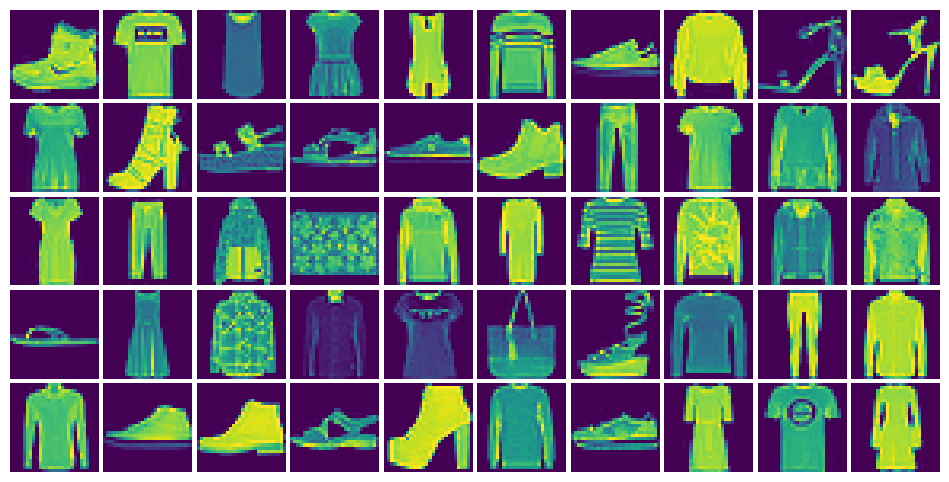

In [16]:
# 画图
plt.figure(figsize=(12, 6))
plt.subplots_adjust(wspace=0.05, hspace=0.05)

for i in range(50):
    plt.subplot(5, 10, i + 1)
    plt.imshow(dst[i][0])
#     plt.title((dir_label[dst[i][1]]))
    plt.axis('off')

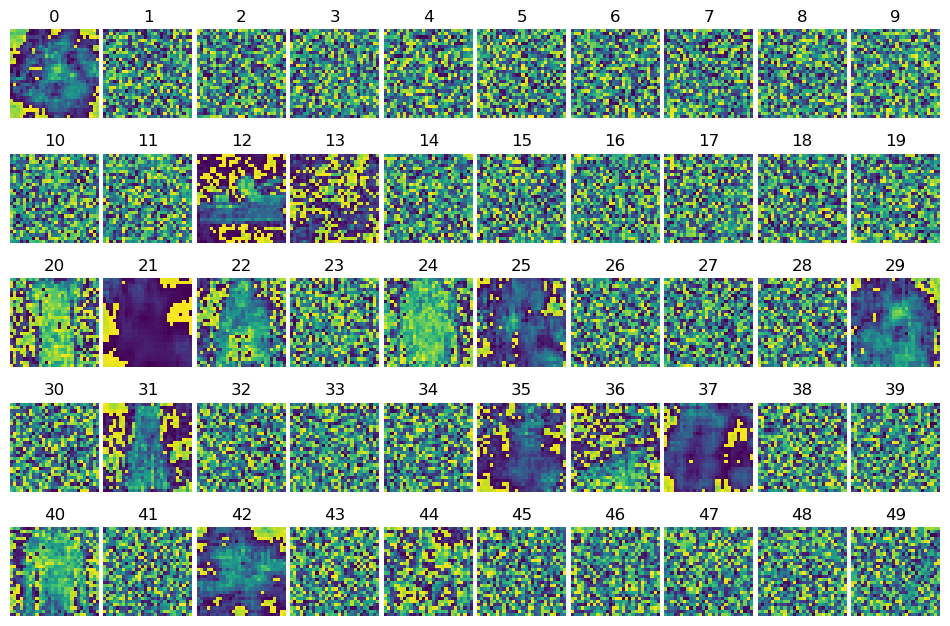

In [25]:
# 画图
plt.figure(figsize=(12, 8))
plt.subplots_adjust(wspace=0.05, hspace=0.05)

for i in range(50):
    plt.subplot(5, 10, i + 1)
    plt.title("{}".format(i))
    plt.imshow(History[i])
    plt.axis('off')

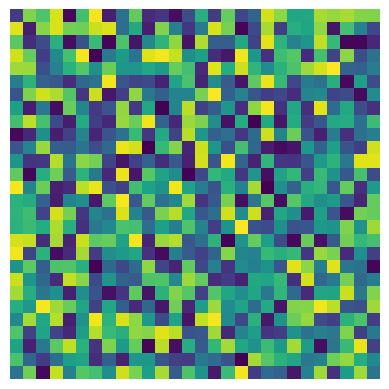

In [20]:
for i in range(50):
    plt.axis('off')
    plt.imshow(History[i])
    plt.savefig('image_dlg_f_{}.png'.format(i), bbox_inches='tight')

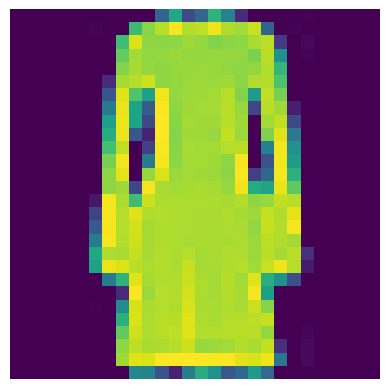

In [21]:
for i in range(50):
    plt.axis('off')
    plt.imshow(dst[i][0])
    plt.savefig('image_r_f_{}.png'.format(i), bbox_inches='tight')

In [ ]:
from skimage.metrics import peak_signal_noise_ratio as psnr
psnr(np.array(dst[img_index][0]), np.array(history[-1]))

# 导入必要的库
from skimage.metrics import structural_similarity as ssim # 使用skimage库中的SSIM函数
import numpy as np # 使用numpy库进行数组操作

# 定义SSIM计算函数
def compare_ssim(img1, img2, maxvalue=255):
    # 将图像转换为浮点数类型
    img1 = np.array(img1).astype(np.float64)
    img2 = np.array(img2).astype(np.float64)
    # 调用skimage库中的SSIM函数，指定数据范围为maxvalue
    return ssim(img1, img2, data_range=maxvalue,win_size=3)

In [ ]:
compare_ssim(dst[img_index][0], history[-1], maxvalue=255)